##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Define constants

In [3]:
# Image sizes
WIDTH = 128
HEIGHT = 128

# Basic classification: Classify images of clothing

In [4]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.8.0


## Import the dataset
First step is to import all data

In [5]:
import load_data
all_img, all_lbl = load_data.load_data()
data_count = len(all_lbl)

print(f'Loaded a total of {len(all_lbl)} elemenets')

Loaded a total of 10000 elemenets


Split into traning and testing

Firstly we create a couple of helper functions

In [6]:
# A list of all unique labels
unique_labels = list(set(np.concatenate(all_lbl)))
label_count = len(unique_labels)

print(f'Dataset contains a total of {len(unique_labels)} labels\n')
print(unique_labels)

def label_to_index(lbl):
    # Is input a single label?
    if isinstance(lbl, str):
        return unique_labels.index(lbl)
    
    # Assume that input is list
    return [ unique_labels.index(l) for l in lbl ]

Dataset contains a total of 116 labels

['Coupe_Vent_Et_Veste_De_Pluie', 'Col_Chemine_Et_Camionneur', 'Col_A_Revers', 'Blazer_Et_Veste_Formelle', 'Pull', 'Coupe_Ample_Ou_Evasee', 'Trench', 'Sous_Les_Hanches', 'Short', 'Col_De_Benitier', 'Pantalon_Carotte', 'Taille_Haute', 'Uni', 'Serigraphie_Et_Illustration', 'Gilet', 'Autres_Rayures', 'Taille_Standard', 'Cape_Et_Poncho', 'Mariniere', 'Confortable_Pour_Hiver', 'Sous_Le_Genou', 'Duffle_Coat', 'Encolure_V_Haut', 'Homewear_Et_Sportswear', 'Doudoune', 'Jacquard', 'Manches_Courtes', 'Grand', 'Perfecto', 'Dentelle', 'Encolure_Carree', 'Hanches', 'Boutons', 'Imprimes', 'Tops_Matiere_Fluide', 'Pantalon', 'Pois', 'Pantalon_A_Pinces', 'Taille_Basse', 'Capuche', 'Encolure_En_Coeur', 'Chemise', 'Tops_Matiere_Droite', 'Coupe_Slim', 'Jupe', 'Manches_Longues', 'Delave', 'Coupe_Cintree_Et_Ajustee', 'Encolure_V_Decollete_Classique_Croise', 'Coupe_Skinny', 'Mini', 'Col_Rond_Haut', 'Camouflage', 'Midi', 'Encolure_V_Decollete_Classique', 'Robe', 'Jupe_Por

In [7]:
validation_split = 0.2

# Labels: string->int
for i,x in enumerate(all_lbl):
    all_lbl[i] = label_to_index(all_lbl[i])
    
# Labels: int->binary matrix
label_bin = np.zeros((data_count, label_count), dtype=int)
for i,lbl in enumerate(all_lbl):
    for index in lbl:
        label_bin[i][index] = 1

# Where should the data be split?
validation_index = int(data_count * validation_split)

test_images = np.array(all_img[:validation_index])
test_labels = label_bin[:validation_index]
train_images = np.array(all_img[validation_index:])
train_labels = label_bin[validation_index:]

In [8]:
# The images needs to be converted from int[0,255] to float[0,1]
print(f'(Example of a pixel) Before: {train_images[0][0][0]}')

test_images = test_images / 255.0
train_images = train_images / 255.0
    
print(f'(Example of a pixel) After: {train_images[0][0][0]}')

(Example of a pixel) Before: [232 174 137]
(Example of a pixel) After: [0.90980392 0.68235294 0.5372549 ]


## Explore the data

This is just to visualize some data.

In [9]:
print(f'Shape of training images: {train_images.shape}')
print(f'Shape of training labels: {train_labels.shape}')

Shape of training images: (8000, 128, 128, 3)
Shape of training labels: (8000, 116)


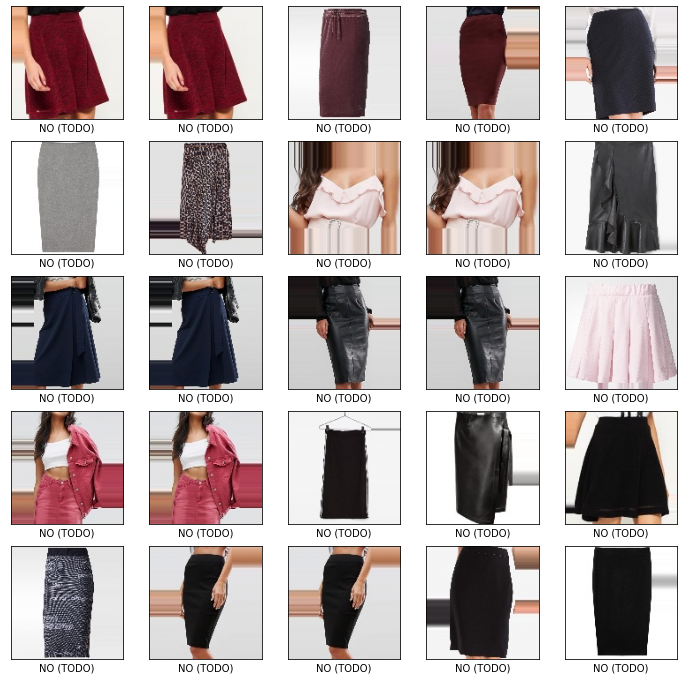

In [10]:
plt.figure(figsize=(12,12))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    #plt.xlabel(train_labels[i])
    #plt.xlabel(label_to_index(train_labels[i]))
    plt.xlabel('NO (TODO)')
plt.show()

## Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

### Set up the layers

The basic building block of a neural network is the [*layer*](https://www.tensorflow.org/api_docs/python/tf/keras/layers). Layers extract representations from the data fed into them. Hopefully, these representations are meaningful for the problem at hand.

Most of deep learning consists of chaining together simple layers. Most layers, such as `tf.keras.layers.Dense`, have parameters that are learned during training.

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(WIDTH, HEIGHT, 3)), # TODO size + colored images?
    tf.keras.layers.Dense(1024, activation='relu'),
    #tf.keras.layers.Dense(10)
    tf.keras.layers.Dense(label_count)
])

The first layer in this network, `tf.keras.layers.Flatten`, transforms the format of the images from a two-dimensional array (of 28 by 28 pixels) to a one-dimensional array (of 28 * 28 = 784 pixels). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two `tf.keras.layers.Dense` layers. These are densely connected, or fully connected, neural layers. The first `Dense` layer has 128 nodes (or neurons). The second (and last) layer returns a logits array with length of 10. Each node contains a score that indicates the current image belongs to one of the 10 classes.



### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's [*compile*](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) step:

* [*Loss function*](https://www.tensorflow.org/api_docs/python/tf/keras/losses) —This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
* [*Optimizer*](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) —This is how the model is updated based on the data it sees and its loss function.
* [*Metrics*](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) —Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.

In [12]:
#model.compile(optimizer='adam',
#              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#              metrics=['accuracy'])

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(), # default from_logits=False
              metrics=[tf.keras.metrics.BinaryAccuracy()])

## Train the model

Training the neural network model requires the following steps:

1. Feed the training data to the model. In this example, the training data is in the `train_images` and `train_labels` arrays.
2. The model learns to associate images and labels.
3. You ask the model to make predictions about a test set—in this example, the `test_images` array.
4. Verify that the predictions match the labels from the `test_labels` array.


### Feed the model

To start training,  call the [`model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) method—so called because it "fits" the model to the training data:

In [14]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
250/250 [==============================] - 74s 279ms/step - loss: 2.0529 - binary_accuracy: 0.8652
Epoch 2/10
250/250 [==============================] - 72s 288ms/step - loss: 2.0003 - binary_accuracy: 0.8693
Epoch 3/10
250/250 [==============================] - 74s 296ms/step - loss: 2.0003 - binary_accuracy: 0.8693
Epoch 4/10
250/250 [==============================] - 65s 258ms/step - loss: 2.0003 - binary_accuracy: 0.8693
Epoch 5/10
250/250 [==============================] - 64s 255ms/step - loss: 2.0003 - binary_accuracy: 0.8693
Epoch 6/10
250/250 [==============================] - 61s 242ms/step - loss: 2.0003 - binary_accuracy: 0.8692
Epoch 7/10
250/250 [==============================] - 62s 246ms/step - loss: 2.0003 - binary_accuracy: 0.8692
Epoch 8/10
250/250 [==============================] - 64s 256ms/step - loss: 2.0003 - binary_accuracy: 0.8693
Epoch 9/10
250/250 [==============================] - 75s 302ms/step - loss: 2.0003 - binary_accuracy: 0.8693
Epoch 10/1

## Export the model
TODO: not tested

In [37]:
from datetime import datetime
t = datetime.now().strftime("%Y%m%d_%H%M%S")
export_path = "./models/broken_data_{}".format(t)
#tf.keras.experimental.export_saved_model(model, export_path)
model.save(export_path)
print("Model with broken data was exported in this path: '{}'".format(export_path))

INFO:tensorflow:Assets written to: ./models/broken_data_20220429_164157\assets
Model with broken data was exported in this path: './models/broken_data_20220429_164157'


In [ ]:
# Load an old model
#model = keras.models.load_model('./models/NAME_HERE')

### Evaluate accuracy

Next, compare how the model performs on the test dataset:

In [15]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

63/63 - 7s - loss: 2.1379 - binary_accuracy: 0.8603 - 7s/epoch - 107ms/step

Test accuracy: 0.8602715134620667


### Make predictions

With the model trained, you can use it to make predictions about some images.
Attach a softmax layer to convert the model's linear outputs—[logits](https://developers.google.com/machine-learning/glossary#logits)—to probabilities, which should be easier to interpret.

In [16]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [17]:
predictions = probability_model.predict(test_images)

Here, the model has predicted the label for each image in the testing set. Let's take a look at the first prediction:

In [30]:
predictions[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [35]:
print(len(predictions))
for p in predictions:
    for i,x in enumerate(p):
        if x > 0 and i != 16:
            print(f'yolo {x}')

2000
yolo 2.83408107833833e-37


A prediction is an array of 10 numbers. They represent the model's "confidence" that the image corresponds to each of the 10 different articles of clothing. You can see which label has the highest confidence value:

In [19]:
x = np.argmax(predictions[0])
print(x)

print(unique_labels[x])

16
Taille_Standard


Graph this to look at the full set of 10 class predictions.

In [20]:
def bin_to_ind(bin):
    return [i for i,x in enumerate(bin) if x == 1]

def soft_max(arr, tol=0.5):
    return [i for i,x in enumerate(arr) if x > tol]

def plot_image(i, predictions_array, true_label_bin, img):
    true_label_bin, img = true_label_bin[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    # Prediction scoring values
    predicted_label = soft_max(predictions_array)
    true_label = bin_to_ind(true_label_bin)
    hits = [x for x in predicted_label if x in true_label]
    hit_count = len(hits)
    true_count = len(true_label)
    false_count = true_count - len(predicted_label)
    hit_percent = hit_count/true_count

    plt.xlabel(f'''
        H: {hit_count}/{true_count} ({hit_percent}%) F: {false_count}
        T: {true_label}
        H: {hits}
    ''',
        color=(1-hit_percent, hit_percent, 0))

def plot_value_array(i, predictions_array, true_label_bin):
    #true_label = bin_to_ind(true_label_bin[i])
    true_label = true_label_bin[i]
    true_count = len(true_label)
    
    plt.grid(False)
    plt.xticks(range(true_count))
    plt.yticks([])
    thisplot = plt.bar(range(true_count), predictions_array, color="#777777", tick_label='')
    plt.ylim([0, 1])
    #predicted_label = np.argmax(predictions_array)

    #thisplot[predicted_label].set_color('red')
    #thisplot[true_label].set_color('blue')

### Verify predictions

With the model trained, you can use it to make predictions about some images.

Let's look at the 0th image, predictions, and prediction array. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percentage (out of 100) for the predicted label.

H: Hits
T: True labels
F: False predictions


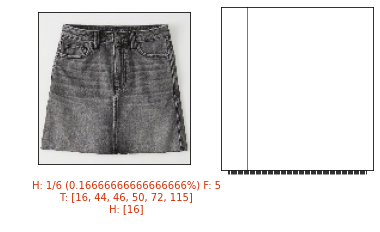

In [21]:
print('H: Hits')
print('T: True labels')
print('F: False predictions')

i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

Let's plot several images with their predictions. Note that the model can be wrong even when very confident.

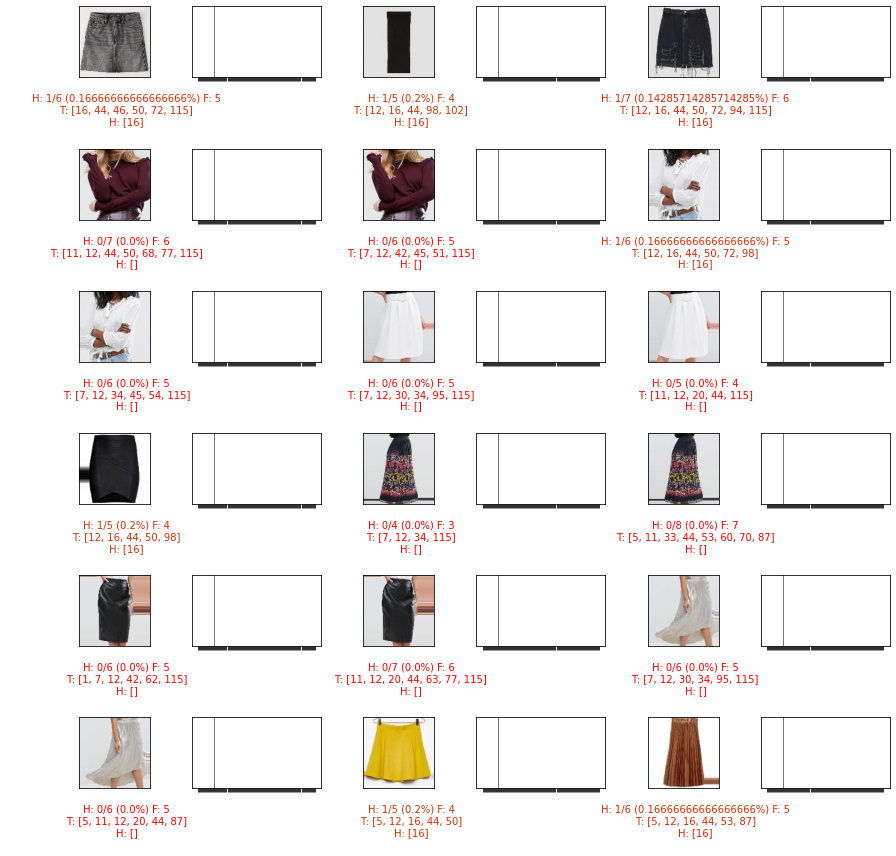

In [22]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 6
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

## Use the trained model

Finally, use the trained model to make a prediction about a single image.

In [23]:
# Grab an image from the test dataset.
img = test_images[1]

print(img.shape)

(128, 128, 3)


`tf.keras` models are optimized to make predictions on a *batch*, or collection, of examples at once. Accordingly, even though you're using a single image, you need to add it to a list:

In [24]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 128, 128, 3)


Now predict the correct label for this image:

In [25]:
predictions_single = probability_model.predict(img)

print(predictions_single)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


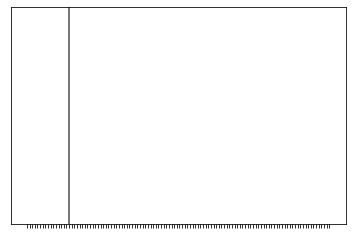

In [26]:
plot_value_array(1, predictions_single[0], test_labels)
#_ = plt.xticks(range(len(predictions_single[0])), range(len(predictions_single[0])), rotation=45)
plt.show()

`tf.keras.Model.predict` returns a list of lists—one list for each image in the batch of data. Grab the predictions for our (only) image in the batch:

In [27]:
np.argmax(predictions_single[0])

16

And the model predicts a label as expected.